回帰直線のようなモデルから生成される妥当なサンプルの範囲を計算する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_excel("./data/real_estate1.xlsx")
df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


In [3]:
stan_model = """
data {
    int N;
    real X[N];
    real Y[N];
    int N_s;
    real X_s[N_s];
    // Y_s[N]; はモデルによって生成されるサンプルなので外部からの入力ではない
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a * X[n] + b, sigma);
    }
}

// できたモデルを使ってMCMCサンプルを発生させるためのブロック
generated quantities {
    real Y_s[N_s];
    for (n in 1:N_s) {
        // gqではイコールを使う
        // gqでは分布に_rngをつける
        Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
    }
}
"""

In [4]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd6d9cd93f8b9897413f8e0724e6deed NOW.


In [6]:
X_s = np.arange(40, 91,1)
N_s = X_s.shape[0]
stan_data = {"N": df.shape[0], "X": df["space"], "Y": df["value"], "N_s": N_s, "X_s": X_s}

In [7]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [8]:
# 確率変数aをサンプリング
fit.extract("a")

OrderedDict([('a',
              array([66.05093606, 88.36239893, 79.56965083, ..., 73.67272216,
                     79.98102546, 65.25613573]))])

In [9]:
ms_a = fit.extract("a")["a"]
ms_a.shape

(4500,)

(array([  10.,   66.,  280.,  857., 1486., 1235.,  434.,  102.,   28.,
           2.]), array([ 32.29667776,  42.10135151,  51.90602525,  61.710699  ,
         71.51537275,  81.3200465 ,  91.12472025, 100.92939399,
        110.73406774, 120.53874149, 130.34341524]), <a list of 10 Patch objects>)

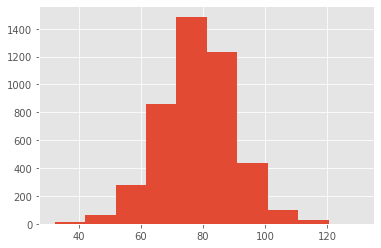

In [10]:
plt.hist(ms_a)

In [11]:
ms_b = fit.extract("b")["b"]

以上から，4500個の直線$ax+b$を得られる．  
この直線集合がベイズ信頼区間になる

In [12]:
# 得られた全てのサンプルを使い，x=40~90の範囲の直線を求める
df_b = pd.DataFrame([])
for i in range(40, 91, 1):
    df_b[i] = ms_a * i + ms_b

df_b

,40,41,42,43,44,45,46,47,48,49,...,81,82,83,84,85,86,87,88,89,90
0,2775.482511,2841.533447,2907.584383,2973.635319,3039.686255,3105.737191,3171.788127,3237.839063,3303.889999,3369.940935,...,5483.570889,5549.621825,5615.672762,5681.723698,5747.774634,5813.825570,5879.876506,5945.927442,6011.978378,6078.029314
1,2157.661301,2246.023700,2334.386099,2422.748498,2511.110897,2599.473296,2687.835695,2776.198094,2864.560493,2952.922892,...,5780.519658,5868.882056,5957.244455,6045.606854,6133.969253,6222.331652,6310.694051,6399.056450,6487.418849,6575.781248
2,2389.453618,2469.023269,2548.592920,2628.162571,2707.732222,2787.301873,2866.871523,2946.441174,3026.010825,3105.580476,...,5651.809302,5731.378953,5810.948604,5890.518255,5970.087906,6049.657557,6129.227207,6208.796858,6288.366509,6367.936160
3,2909.384319,2972.941945,3036.499571,3100.057198,3163.614824,3227.172450,3290.730076,3354.287702,3417.845328,3481.402954,...,5515.246991,5578.804618,5642.362244,5705.919870,5769.477496,5833.035122,5896.592748,5960.150375,6023.708001,6087.265627
4,2087.494976,2170.255724,2253.016473,2335.777222,2418.537971,2501.298720,2584.059468,2666.820217,2749.580966,2832.341715,...,5480.685675,5563.446424,5646.207173,5728.967922,5811.728671,5894.489419,5977.250168,6060.010917,6142.771666,6225.532414
5,2265.696293,2349.352819,2433.009345,2516.665872,2600.322398,2683.978924,2767.635451,2851.291977,2934.948503,3018.605030,...,5695.613874,5779.270400,5862.926926,5946.583453,6030.239979,6113.896505,6197.553032,6281.209558,6364.866085,6448.522611
6,2423.661382,2501.376189,2579.090996,2656.805803,2734.520610,2812.235417,2889.950224,2967.665031,3045.379838,3123.094645,...,5609.968468,5687.683275,5765.398082,5843.112889,5920.827696,5998.542503,6076.257310,6153.972117,6231.686924,6309.401731
7,2491.803750,2565.258683,2638.713616,2712.168549,2785.623482,2859.078415,2932.533347,3005.988280,3079.443213,3152.898146,...,5503.455999,5576.910932,5650.365865,5723.820797,5797.275730,5870.730663,5944.185596,6017.640529,6091.095462,6164.550395
8,2237.603113,2319.757288,2401.911464,2484.065640,2566.219816,2648.373991,2730.528167,2812.682343,2894.836519,2976.990694,...,5605.924319,5688.078494,5770.232670,5852.386846,5934.541022,6016.695198,6098.849373,6181.003549,6263.157725,6345.311901
9,1913.405726,2007.810992,2102.216257,2196.621522,2291.026787,2385.432053,2479.837318,2574.242583,2668.647848,2763.053114,...,5784.021601,5878.426867,5972.832132,6067.237397,6161.642662,6256.047927,6350.453193,6444.858458,6539.263723,6633.668988


In [13]:
# 50%信頼区間を求める
# 生成されたサンプルの50%はこの中に入る，という区間
# 全体を0~1とした時，左25%, 右75%で分割できる点を探す
# quantiles: 分位数
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)

# 95%信頼区間を求める
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

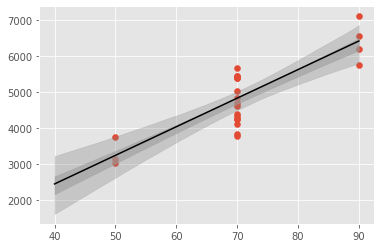

In [14]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")
a = 79.3
b = -713.7
y = a * X_s + b
plt.plot(X_s, y, color="black")

このように，パラメータの信頼区間から導かれる妥当なサンプルの範囲をベイズ信頼区間と呼ぶ．  
データが多いところほど，パラメータの期待値が明確になるため，信頼区間は狭くなる

続いて，ベイズ予測区間について  

In [15]:
Y_p = fit.extract("Y_s")["Y_s"]

In [16]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

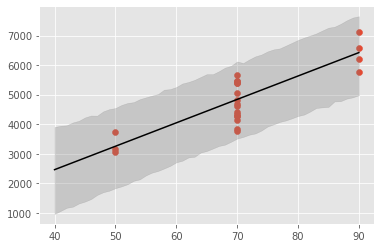

In [17]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")
a = 79.3
b = -713.7
y = a * X_s + b
plt.plot(X_s, y, color="black")

このように，モデルから生成されたサンプルそのものから導かれる妥当なサンプルの範囲をベイズ予測区間と呼ぶ.

期待値からの誤差が全て正規分布に従うため，信頼区間よりも広く見える．  